# Load data

In [1]:
import numpy as np
import pandas as pd
import anndata
import os

In [2]:
ddir = '/bigstore/GeneralStorage/fangming/projects/visctx/data_dump/counts/'
resdir = '/bigstore/GeneralStorage/fangming/projects/visctx/data_dump/test_propose'
f = os.path.join(ddir, "P38_1a2a_glut.h5ad")
adata = anndata.read(f)
adata

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 3751 × 53547
    obs: 'cov', 'covfactor', 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass'
    var: 'id'

In [3]:
raw = np.asarray(adata.X.todense())
raw

array([[ 0.,  0., 12., ...,  0.,  0.,  0.],
       [ 0.,  0., 20., ...,  0.,  0.,  0.],
       [ 0.,  0.,  8., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0., 10., ...,  0.,  0.,  0.],
       [ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  3., ...,  0.,  0.,  0.]], dtype=float32)

In [4]:
cpm = (raw/raw.sum(axis=1).reshape(-1,1))*1e6
cpm

array([[   0.     ,    0.     , 1411.2666 , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     , 1475.2527 , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,  495.84726, ...,    0.     ,    0.     ,
           0.     ],
       ...,
       [   0.     ,    0.     ,  693.0487 , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,  301.24112, ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,  304.94003, ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)

In [5]:
gene_names = adata.var.index.values

cell_types = adata.obs['Type']
cell_types_num = pd.Categorical(cell_types).codes
cell_types, cell_types_num

(AAACCCAAGTGACACG-1-P38_1a-P38    L2/3_B
 AAACGCTAGTACAGAT-1-P38_1a-P38      L4_C
 AAACGCTAGTGAGGCT-1-P38_1a-P38      L4_C
 AAACGCTGTATGGAAT-1-P38_1a-P38      L4_B
 AAAGAACAGTAGTCCT-1-P38_1a-P38      L4_C
                                   ...  
 TTTGATCTCTACTGCC-1-P38_2a-P38      L4_B
 TTTGGAGTCACCTACC-1-P38_2a-P38    L2/3_A
 TTTGGTTCAAGCTCTA-1-P38_2a-P38    L2/3_C
 TTTGGTTCAGCTTTCC-1-P38_2a-P38    L2/3_A
 TTTGTTGAGATTGGGC-1-P38_2a-P38    L2/3_A
 Name: Type, Length: 3751, dtype: category
 Categories (10, object): ['L2/3_B', 'L4_A', 'L6CT_B', 'L4_B', ..., 'L4_C', 'L5PT_A', 'L2/3_A', 'L2/3_C'],
 array([0, 6, 6, ..., 9, 8, 8], dtype=int8))

In [6]:
# Generate logarithmized and binarized data
binary = (raw > 0).astype(np.float32)
log = np.log(1 + raw)
logcpm = np.log(1 + cpm)

In [7]:
# For data splitting
n = len(raw)
n_train = int(0.8 * n)
n_test = int(0.1 * n)
all_rows = np.arange(n)
np.random.seed(0)
np.random.shuffle(all_rows)
train_inds = all_rows[:n_train]
val_inds = all_rows[n_train:-n_test]
test_inds = all_rows[-n_test:]
print(f'{n} total examples, {len(train_inds)} training examples, {len(val_inds)} validation examples, {len(test_inds)} test examples')

3751 total examples, 3000 training examples, 376 validation examples, 375 test examples


# Run PROPOSE for cell type classification

In [8]:
import torch
import pickle
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "/bigstore/GeneralStorage/fangming/projects/visctx/propose")
from propose import PROPOSE, HurdleLoss, ExpressionDataset
from propose import models, Accuracy

In [9]:
# Set up GPU device
device = torch.device('cpu') #'cpu' #torch.device('cuda', 5)

In [10]:
# # Make cell types numerical
# cell_types = pd.Categorical(cell_types_98).codes

# Set up datasets
train_dataset = ExpressionDataset(binary[train_inds], cell_types_num[train_inds])
val_dataset = ExpressionDataset(binary[val_inds], cell_types_num[val_inds])

In [15]:
# Number of genes to select
num_genes = [16]
propose_class_results = {}

In [12]:
# Set up selector
selector = PROPOSE(train_dataset,
                   val_dataset,
                   loss_fn=torch.nn.CrossEntropyLoss(),
                   device=device,
                   hidden=[128, 128])

# Eliminate many candidates
candidates, model = selector.eliminate(target=500, mbsize=128, max_nepochs=10)

using CrossEntropyLoss, starting with lam = 0.0001


Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

lam = 0.000100 yielded 53547 genes
Warm starting model for next iteration
next attempt is lam = 0.001000


Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

lam = 0.001000 yielded 53547 genes
Warm starting model for next iteration
next attempt is lam = 0.010000


Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

lam = 0.010000 yielded 53547 genes
Warm starting model for next iteration
next attempt is lam = 0.100000


Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

lam = 0.100000 yielded 53547 genes
Warm starting model for next iteration
next attempt is lam = 1.000000


Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

lam = 1.000000 yielded 53547 genes
Warm starting model for next iteration
next attempt is lam = 10.000000


Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

lam = 10.000000 yielded 53547 genes
Warm starting model for next iteration
next attempt is lam = 100.000000


Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

lam = 100.000000 yielded 53547 genes
Warm starting model for next iteration
next attempt is lam = 1000.000000


Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

lam = 1000.000000 yielded 53547 genes
Warm starting model for next iteration
next attempt is lam = 2977.333150


Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

lam = 2977.333150 yielded 53547 genes
Warm starting model for next iteration
next attempt is lam = 4954.666300


Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

lam = 4954.666300 yielded 3141 genes
Warm starting model for next iteration
next attempt is lam = 6632.405666


ValueError: reached maximum number of trials without selecting the desired number of genes! The results may have large variance due to small dataset size, or the initial lam value may be bad

In [16]:
for num in num_genes:
    # Select specific number of genes
    inds, model = selector.select(num_genes=num, mbsize=128, max_nepochs=10)
    propose_class_results[num] = inds

Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

done, selected 16 genes


In [17]:
# Save results
with open(os.path.join(resdir, 'propose_class_results.pkl'), 'wb') as f:
    pickle.dump(propose_class_results, f)

# Cell type classification metric

In [34]:
# Set up datasets
train_dataset = ExpressionDataset(binary[train_inds], cell_types_num[train_inds])
val_dataset = ExpressionDataset(binary[val_inds], cell_types_num[val_inds])
test_dataset = ExpressionDataset(binary[test_inds], cell_types_num[test_inds])

In [35]:
# Prepare gene sets
with open(os.path.join(resdir, 'propose_class_results.pkl'), 'rb') as f:
    propose_class_results = pickle.load(f)
num_genes = list(propose_class_results.keys())

# Dictionary of methods
methods = {
    'PROPOSE-Class': propose_class_results,
}

# Dictionary of results
results = {name: {} for name in methods}

In [36]:
# Fit models
for name in methods:
    for num in num_genes:
        # Get inds
        inds = methods[name][num]
        
        # Set up datasets
        train_dataset.set_inds(inds)
        val_dataset.set_inds(inds)
        test_dataset.set_inds(inds)
        
        # Train model
        model = models.MLP(
            input_size=num,
            output_size=train_dataset.output_size,
            hidden=[128, 128]).to(device)
        model.fit(
            train_dataset,
            val_dataset,
            mbsize=512,
            max_nepochs=500,
            loss_fn=torch.nn.CrossEntropyLoss(),
            verbose=False)

        # Validation performance
        test_acc = model.validate(DataLoader(test_dataset, batch_size=1024), Accuracy()).item()
        results[name][num] = test_acc

In [37]:
# Save results
with open(os.path.join(resdir, 'classification_metric.pkl'), 'wb') as f:
    pickle.dump(results, f)

In [38]:
# Plot results
with open(os.path.join(resdir, 'classification_metric.pkl'), 'rb') as f:
    results = pickle.load(f)
num_features = list(results['PROPOSE-Class'].keys())

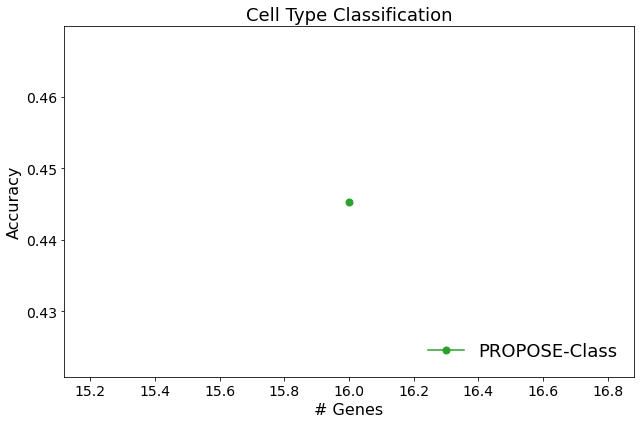

In [39]:
# Make plot
plt.figure(figsize=(9, 6))
plt.plot(num_features, [results['PROPOSE-Class'][num] for num in num_features],
         marker='o', markersize=7, color='C2', label='PROPOSE-Class')
plt.legend(loc='lower right', fontsize=18, frameon=False)
plt.tick_params(labelsize=14)
plt.title('Cell Type Classification', fontsize=18)
plt.xlabel('# Genes', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.tight_layout()
plt.show()